In [1]:
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import matplotlib.pyplot as plt
# text processing
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
# keras deep network
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
# result evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics
# saving model
from keras.models import model_from_json

### emotion dataset source: https://www.kaggle.com/praveengovi/emotions-dataset-for-nlp

In [2]:
# list sentences
def create_df(path):
    """
    create data frame from text format
    """
    list_sent = []
    all_sent = []
    with open(path) as f:
        # read line by line
        for line in f:
        # remove whitespace at the start and the newline at the end
            line = line.strip()
            list_sent.append(line)
        for i in range(len(list_sent)):
        # data were seperated using semicolon
            all_sent.append(list_sent[i].split(';'))
        df = pd.DataFrame(all_sent, columns=['description','emotion'])
        return df

#### training dataset

In [3]:
# train dataset
train = create_df('C:/Users/hamro/Desktop/finished_projects/emotion_datasets/emotions/train.txt')
train

,description,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
15995,i just had a very brief time in the beanbag an...,sadness
15996,i am now turning and i feel pathetic that i am...,sadness
15997,i feel strong and good overall,joy
15998,i feel like this was such a rude comment and i...,anger


In [4]:
print("missing values: ")
print(train.isnull().sum(), '\n')
print("shape: ", train.shape)

missing values: 
description    0
emotion        0
dtype: int64 

shape:  (16000, 2)


#### validation dataset

In [5]:
# validation dataset
val = create_df('C:/Users/hamro/Desktop/finished_projects/emotion_datasets/emotions/val.txt')

In [6]:
val.head(5)

,description,emotion
0,im feeling quite sad and sorry for myself but ...,sadness
1,i feel like i am still looking at a blank canv...,sadness
2,i feel like a faithful servant,love
3,i am just feeling cranky and blue,anger
4,i can have for a treat or if i am feeling festive,joy


In [7]:
print("missing values: ")
print(val.isnull().sum(), '\n')
print("shape: ", val.shape)

missing values: 
description    0
emotion        0
dtype: int64 

shape:  (2000, 2)


#### testing dataset

In [8]:
# testing dataset
test = create_df('C:/Users/hamro/Desktop/finished_projects/emotion_datasets/emotions/test.txt')
test.head(5)

,description,emotion
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness


In [9]:
print("missing values: ")
print(test.isnull().sum(), '\n')
print("shape: ", test.shape)

missing values: 
description    0
emotion        0
dtype: int64 

shape:  (2000, 2)


### EDA - positive and negative emotions are roughly in a ratio of 1:1

In [10]:
vals = train['emotion'].value_counts()

C:\Users\hamro\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


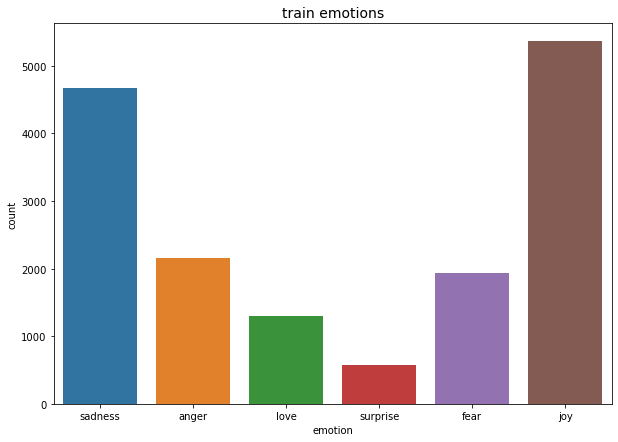

In [11]:
fig = plt.figure(figsize=(10,7))
sns.countplot(train['emotion'])
plt.title('train emotions', fontsize=14)
plt.show()

C:\Users\hamro\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


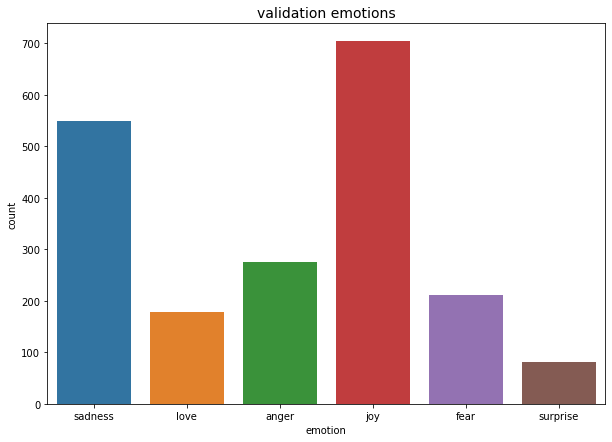

In [12]:
fig = plt.figure(figsize=(10,7))
sns.countplot(val['emotion'])
plt.title('validation emotions', fontsize=14)
plt.show()

C:\Users\hamro\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


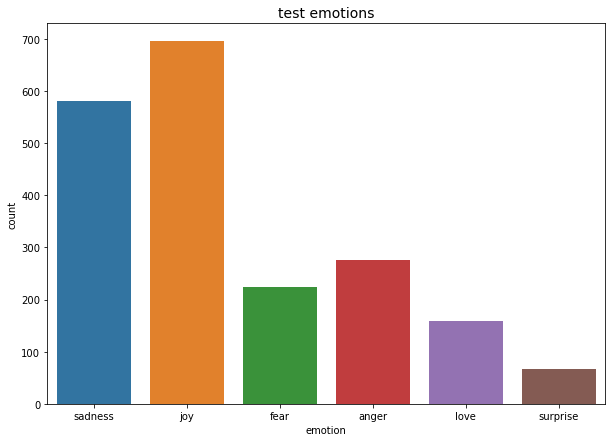

In [13]:
fig = plt.figure(figsize=(10,7))
sns.countplot(test['emotion'])
plt.title('test emotions', fontsize=14)
plt.show()

### how many words have sentences?

In [14]:
num_of_words_train = []
num_of_words_val = []
num_of_words_test = []
for i in range(train['description'].size):
    num_of_words_train.append([len(train['description'].loc[i].split(" "))])

for i in range(val['description'].size):
    num_of_words_val.append([len(val['description'].loc[i].split(" "))])

for i in range(test['description'].size):
    num_of_words_test.append([len(test['description'].loc[i].split(" "))])

n_train = pd.DataFrame(num_of_words_train, columns=['num_words_train'])
n_val = pd.DataFrame(num_of_words_val, columns=['num_words_val'])
n_test = pd.DataFrame(num_of_words_test, columns=['num_words_test'])
n_train.head(5)

,num_words_train
0,4
1,21
2,10
3,18
4,4


### how many words per sentence in train dataset

In [15]:
# training dataset
train_over = n_train[n_train > 34].count()
_train= train_over/len(n_train)
# val dataset
val_over = n_val[n_val > 34].count()
_val= val_over/len(n_val)
# test dataset
test_over = n_test[n_test > 34].count()
_test= test_over/len(n_test)

C:\Users\hamro\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\hamro\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\hamro\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


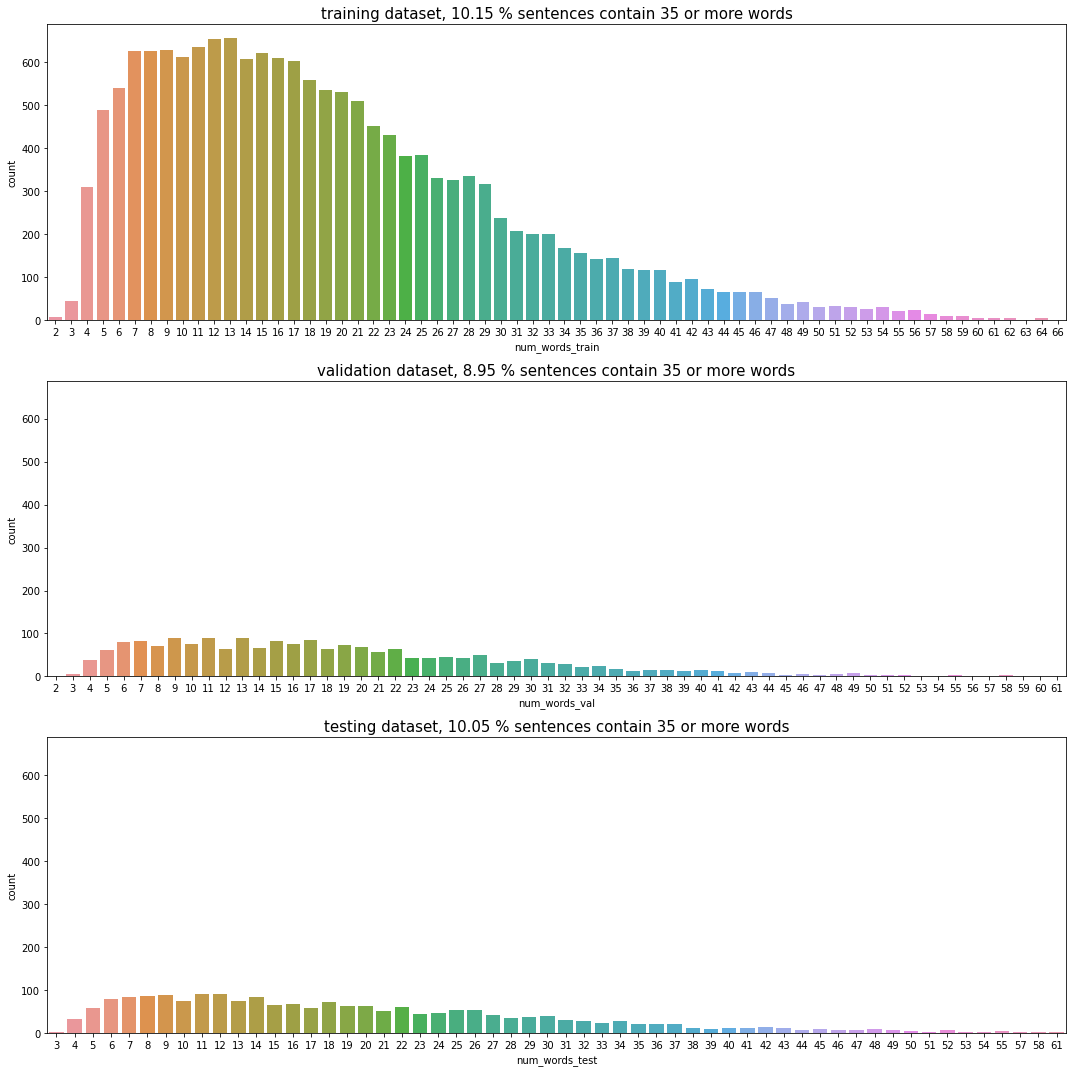

In [16]:
fig, axes = plt.subplots(3, 1, figsize=(15, 15), sharey=True)
sns.countplot(n_train['num_words_train'], ax=axes[0])
axes[0].set_title(f"training dataset, {round(_train[0]*100,2)} % sentences contain 35 or more words", fontsize=15)
sns.countplot(n_val['num_words_val'], ax=axes[1])
axes[1].set_title(f"validation dataset, {round(_val[0]*100,2)} % sentences contain 35 or more words", fontsize=15)
sns.countplot(n_test['num_words_test'], ax=axes[2])
axes[2].set_title(f"testing dataset, {round(_test[0]*100,2)} % sentences contain 35 or more words", fontsize=15)
plt.tight_layout()
plt.show()

### creating only 2 main emotion groups - positive and negative

In [17]:
def distinguish_emotions(emotion):
    if emotion == 'joy' or emotion == 'love' or emotion == 'surprise':
        return 1
    else:
        return 0


#### training dataset

In [18]:
train['emotion_class'] = train['emotion'].apply(distinguish_emotions)
train.head()

,description,emotion,emotion_class
0,i didnt feel humiliated,sadness,0
1,i can go from feeling so hopeless to so damned...,sadness,0
2,im grabbing a minute to post i feel greedy wrong,anger,0
3,i am ever feeling nostalgic about the fireplac...,love,1
4,i am feeling grouchy,anger,0


#### training data - data, target

In [19]:
X_train = train['description']
target_train = train['emotion_class']

#### validation dataset

In [20]:
val['emotion_class'] = val['emotion'].apply(distinguish_emotions)
val.head()

,description,emotion,emotion_class
0,im feeling quite sad and sorry for myself but ...,sadness,0
1,i feel like i am still looking at a blank canv...,sadness,0
2,i feel like a faithful servant,love,1
3,i am just feeling cranky and blue,anger,0
4,i can have for a treat or if i am feeling festive,joy,1


#### validation data - val, target

In [21]:
X_val = val['description']
target_val = val['emotion_class']

#### testing dataset

In [22]:
test['emotion_class'] = test['emotion'].apply(distinguish_emotions)
test.head()

,description,emotion,emotion_class
0,im feeling rather rotten so im not very ambiti...,sadness,0
1,im updating my blog because i feel shitty,sadness,0
2,i never make her separate from me because i do...,sadness,0
3,i left with my bouquet of red and yellow tulip...,joy,1
4,i was feeling a little vain when i did this one,sadness,0


In [23]:
X_test = test['description']
target_test = test['emotion_class']

### text preprocession

In [24]:
def preprocessing(data):    
    ps = PorterStemmer()
    corpus = []
    for i in data:
        review = re.sub('[^a-zA-Z]', ' ', i)
        review = review.lower()
        review = review.split()
        review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
        review = ' '.join(review)
        if review != '':
            corpus.append(review)
    return corpus

### vectorizing text and creating embedded layer with fixed lenght set to 35 words per sentence

In [25]:
def vectorize_sentence(corpus):
    # Vocabulary size
    voc_size=10000
    onehot_repr=[one_hot(words,voc_size)for words in corpus] 
    # creating embedding layer as the input layer for our model we fixed lenght set to 20
    sent_length=35
    # pad sequence - we have to always input vector of the same size, but sentences are of 
    embedded_words=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
    return embedded_words

In [26]:
def input_layer(data):
    corpus = preprocessing(data)
    embedded_input = vectorize_sentence(corpus)
    return embedded_input

### training input

In [27]:
input_train = input_layer(X_train)

### validation input

In [28]:
input_val = input_layer(X_val)

### test input

In [29]:
input_test = input_layer(X_test)

### create model (NN) - input: embedded layer with fixed length set to 30, hidden layer - LSTM layer, output - one value (using Sigmoid function) 


In [30]:
## Creating model
voc_size=10000
input_length = 35
embedding_vector_features=100
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=input_length))
model.add(Dropout(0.4))
model.add(LSTM(50))
model.add(Dropout(0.4))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 35, 100)           1000000   
_________________________________________________________________
dropout (Dropout)            (None, 35, 100)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 50)                30200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 1,030,251
Trainable params: 1,030,251
Non-trainable params: 0
_________________________________________________________________
None


### prepare input data

In [31]:
# training data
X_train=np.array(input_train)
y_train=np.array(target_train)
# validation data
X_val = np.array(input_val)
y_val = np.array(target_val)
# testing data
X_test = np.array(input_test)
y_test = np.array(target_test)

In [32]:
# implementing early stopping
early_stopping = keras.callbacks.EarlyStopping(
    # if val loss increases 5 epochs in a row
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)

In [33]:
# Training
# verbose 0 - hides output - too many epochs

history = model.fit(X_train,y_train,
                    validation_data=(X_val,y_val),
                    epochs=4,
                    batch_size=128,
                    callbacks=[early_stopping],
                    verbose = 0,
                   ) 

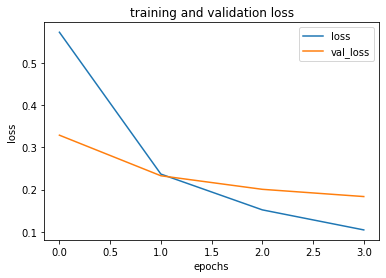

In [34]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
plt.title("training and validation loss")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

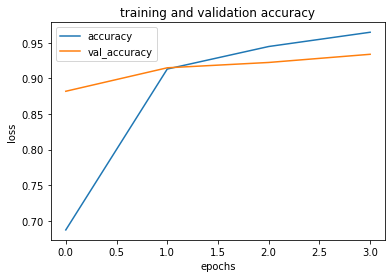

In [64]:
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
plt.title("training and validation accuracy")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()


### evaluate our model, prediction, test

In [36]:
predictions = (model.predict(X_test) > 0.5).astype("int32")

In [37]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,predictions)

0.939

In [38]:
confusion_matrix(y_test,predictions)

array([[1019,   61],
       [  61,  859]], dtype=int64)

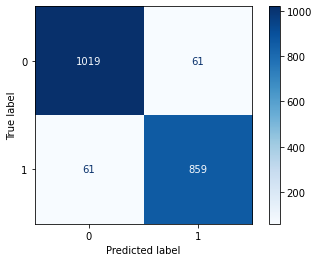

In [39]:
cm = confusion_matrix(y_test,predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()


### we could possibly care more about recall, as it's very unpleasant for a patient when the patient is in a good mood but we define it as a bad mood

In [40]:
print(metrics.classification_report(predictions, y_test))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      1080
           1       0.93      0.93      0.93       920

    accuracy                           0.94      2000
   macro avg       0.94      0.94      0.94      2000
weighted avg       0.94      0.94      0.94      2000



### playing with the model 

In [56]:
text = "I have an issue with regulation emotions. I am frustrated. I love Deja."

In [57]:
text = text.split('.')

In [58]:
text = input_layer(text)

In [61]:
pred = (model.predict(text) > 0.5).astype("int32")
pred

array([[0],
       [0],
       [1]])

### sentence sentiment

In [62]:
# prediction for each sentence
for i in range(len(text)):
    if pred[i] == 0:
        print(f"{i+1}. sentence is negative")
    else:
        print(f"{i+1}. sentence is possitive")

1. sentence is negative
2. sentence is negative
3. sentence is possitive


### average text sentiment

In [63]:
# average text sentiment
pred = round(np.average(pred),2)
if pred < 0.5:
    print("the whole text is mostly negative")
else:
    print("the whole text is mostly negative")

the whole text is mostly negative
